In [1]:
import pandas as pd
import yaml
import random
import re
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.layers import LayerNormalization,BatchNormalization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, GRU, Dropout, Conv1D, MaxPooling1D
from tensorflow.keras.models import model_from_yaml
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping

np.set_printoptions(suppress=True)

In [2]:
def readFile(filePath):
    lemma_result = pd.read_csv(filePath)
    print(lemma_result.shape)
    return lemma_result

In [3]:
def checkLength(max_feat, file):
    leng = 0
    sentence = []
    allData = file['cleaned_review']

    max_fatures = max_feat
    tokenizer = Tokenizer(num_words=max_fatures, split=' ') 
    tokenizer.fit_on_texts(allData.values)
    X1 = tokenizer.texts_to_sequences(allData.values)
    
    for i in X1:
        if len(i)>leng:
            leng = len(i)
            sentence = i
    print(leng)
    print(sentence)
    return leng

In [4]:
def beforeCreateModel(max_feat,dataset,max_length):
    max_fatures = max_feat #จำนวนคำที่ใช้ใน model
    tokenizer = Tokenizer(num_words=max_fatures, split=' ') 
    tokenizer.fit_on_texts(dataset['cleaned_review'].values)
    X1 = tokenizer.texts_to_sequences(dataset['cleaned_review'].values)
    print(len(tokenizer.word_index))
    feat = pad_sequences(X1, padding='pre',maxlen=max_length) # 505 = max_length in sentence
    target = dataset['Label'].values

    return feat,target,tokenizer

In [5]:
def createModelLSTM(embed_dim,lstm_out,max_feat,input_length):
    embed_dim = embed_dim
    lstm_out = lstm_out
    model = Sequential() #Create Model
    model.add(Embedding(input_dim = max_feat ,output_dim = embed_dim ,input_length = input_length)) #Input Layer
    model.add(LSTM(lstm_out, dropout=0.2)) #1st hidden Layer
    model.add(Dropout(0.5))
    model.add(Dense(1,activation='sigmoid')) # Output Layer
    model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])
    print(model.summary())
    return model

In [6]:
def createModelGRU(embed_dim,gru_out,max_feat,input_length):
    embed_dim = embed_dim
    gru_out = gru_out
    model = Sequential()
    model.add(Embedding(input_dim = max_feat ,output_dim = embed_dim ,input_length = input_length)) #Input Layer
    model.add(Dropout(0.2))
    model.add(Conv1D(64, 5, activation='relu'))
    model.add(MaxPooling1D(pool_size=4))
    model.add(GRU(100)) #1st hidden Layer
    model.add(Dense(1,activation='sigmoid')) # Output Layer
    model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])
    print(model.summary())
    return model

In [7]:
def trainModel(model,feat,target,validation_split,epochs,batch_size):
    random.seed(10)
    history = model.fit(feat, target,validation_split=validation_split, epochs = epochs, batch_size=batch_size)
    return history

In [8]:
def evaluateModel(model,feat,target,batch_size):
    score,acc = model.evaluate(feat, target, verbose = 2, batch_size = batch_size)
    print("score: %.2f" % (score))
    print("acc: %.2f" % (acc))

In [9]:
def plotLoss(history):
    loss_values = history.history['loss']
    val_loss_values = history.history['val_loss']
    epochs = range(1, len(loss_values)+1)

    plt.plot(epochs, loss_values, label='Training Loss')
    plt.plot(epochs, val_loss_values, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [10]:
def saveModel(model):
    # serialize model to YAML
    model_yaml = model.to_yaml()
    with open("Summary.yaml", "w") as yaml_file:
        yaml_file.write(model_yaml)
    # serialize weights to HDF5
    model.save_weights("Weights.h5")
    print("Saved model to disk")

In [11]:
def loadModel(yamlPathName, h5PathName):
    with open(yamlPathName+'.yaml', 'r') as yaml_file:
        print(yamlPathName)
        loaded_model_yaml = yaml_file.read()
        loaded_model = model_from_yaml(loaded_model_yaml)
        loaded_model.load_weights(h5PathName+'.h5')
    loaded_model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])
    return loaded_model

In [12]:
def filterAndShow(filter1, filter2, modelOutput, labelTest):
    print(modelOutput)
    test = []
    test_y = []

    for i in range(len(modelOutput)):
        if(modelOutput[i] <filter1 or modelOutput[i]>filter2):
            test.append(modelOutput[i])
            test_y.append(labelTest[i])

    test1 = np.array(test)
    testy1 = np.array(test_y)
    print(testy1)
    print(test1.shape)
    print(testy1.shape)
    showConfusionMatrix(testy1, test1)

In [13]:
def showConfusionMatrix(trueLabel,resultToShow):
    labels = ['positive','negative']
    cm = confusion_matrix(y_true=trueLabel , y_pred=resultToShow>0.5)
    print(cm)

In [14]:
def showWordWithCode(dataToMap, tokenizer): #dataToMap = list of sentiment
    reverse_word_map = dict(map(reversed, tokenizer.word_index.items())) # map id to all word in dic
    print(reverse_word_map)
    
    def sequence_to_text(list_of_indices):
        # Looking up words in dictionary
        words = [reverse_word_map.get(letter) for letter in list_of_indices]
        return(words)
    
    my_texts = list(map(sequence_to_text, dataToMap))
    #my_texts
    return reverse_word_map

In [15]:
def saveSentimentAndResult(sentenceToSave, resultToSave):
    sen_temp = ""
    SentimentSave = []
    for one_sentence in sentenceToSave:
        for word in one_sentence:
            if isinstance(word, str):
                sen_temp = sen_temp + " " + word
            
        SentimentSave.append(sen_temp)
        sen_temp = ""
            
    #make 1 Dim predict result
    resultSave = []
    for arr_result in resultToSave:
        for result in arr_result:
            #print(result)
            resultSave.append(result)
            
    data = {'lemma_review': SentimentSave, 'predict score': resultSave}
    toFile = pd.DataFrame(data)
    toFile.to_csv("./for_compare.csv", index=False)

Test

In [16]:
MAX_FEATURE = 3800

In [17]:
path = "../Clean/lemma_result_rotten_data_text.csv"
x = readFile(path)

(10000, 2)


In [18]:
max_length = checkLength(MAX_FEATURE,x)

28
[3344, 66, 867, 10, 5, 2, 199, 3191, 99, 653, 4, 2387, 2636, 818, 2908, 1409, 923, 653, 200, 3, 370, 76, 122, 27, 5, 624, 1023, 1772]


In [19]:
feat,target,tokenizer = beforeCreateModel(max_feat=MAX_FEATURE,dataset=x,max_length=max_length)

feat,target

16946


(array([[   0,    0,    0, ..., 3177,  120, 1875],
        [   0,    0,    0, ...,   11, 1078,   53],
        [   0,    0,    0, ...,  376,  125,   47],
        ...,
        [   0,    0,    0, ...,  360,  146,   79],
        [   0,    0,    0, ..., 1428,    1, 1924],
        [   0,    0,    0, ...,  486,  567, 1471]]),
 array([1, 1, 0, ..., 1, 0, 0], dtype=int64))

In [20]:
X_train, X_test, Y_train, Y_test = train_test_split(feat,target, test_size = 0.2, train_size = 0.8, random_state = 10)

GRU

In [21]:
embed_dim=128
gru_out=32

model = createModelGRU(embed_dim=embed_dim,gru_out=gru_out,max_feat=MAX_FEATURE,input_length=feat.shape[1])
print("Input Shape is " + str(feat.shape[1]))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 28, 128)           486400    
_________________________________________________________________
dropout (Dropout)            (None, 28, 128)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 24, 64)            41024     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 6, 64)             0         
_________________________________________________________________
gru (GRU)                    (None, 100)               49800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 577,325
Trainable params: 577,325
Non-trainable params: 0
__________________________________________________

In [22]:
#history = trainModel(model,feat=X_train,target=Y_train,validation_split=0.2,epochs=15,batch_size=32)
random.seed(10)
history = model.fit(X_train, 
                    Y_train,
                    validation_data=(X_test, Y_test), 
                    epochs = 10, 
                    batch_size=32)

Train on 8000 samples, validate on 2000 samples
Epoch 1/10
8000/8000 [==============================] - 6s 702us/sample - loss: 0.6431 - accuracy: 0.6156 - val_loss: 0.5707 - val_accuracy: 0.7100
Epoch 2/10
8000/8000 [==============================] - 3s 437us/sample - loss: 0.4404 - accuracy: 0.7943 - val_loss: 0.5806 - val_accuracy: 0.7055
Epoch 3/10
8000/8000 [==============================] - 3s 425us/sample - loss: 0.2475 - accuracy: 0.8996 - val_loss: 0.7620 - val_accuracy: 0.6710
Epoch 4/10
8000/8000 [==============================] - 3s 424us/sample - loss: 0.0815 - accuracy: 0.9700 - val_loss: 1.2367 - val_accuracy: 0.6690
Epoch 5/10
8000/8000 [==============================] - 3s 432us/sample - loss: 0.0350 - accuracy: 0.9879 - val_loss: 1.6290 - val_accuracy: 0.6850
Epoch 6/10
8000/8000 [==============================] - 3s 423us/sample - loss: 0.0197 - accuracy: 0.9929 - val_loss: 1.8961 - val_accuracy: 0.6760
Epoch 7/10
8000/8000 [==============================] - 3s 433us

In [23]:
evaluateModel(model,feat=X_test,target=Y_test,batch_size=32)

2000/2000 - 0s - loss: 2.2629 - accuracy: 0.6830
score: 2.26
acc: 0.68


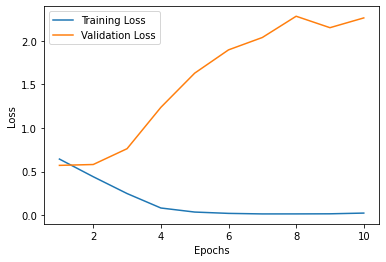

In [24]:
plotLoss(history=history)

In [25]:
result=model.predict(X_test)

In [26]:
showConfusionMatrix(trueLabel=Y_test,resultToShow=result)

[[678 347]
 [287 688]]


Web Test

In [27]:
def beforeCreateModelTest(max_feat,dataset,max_length):
    max_fatures = max_feat
    X1 = tokenizer.texts_to_sequences(dataset['cleaned_review'].values)
    print(len(tokenizer.word_index))
    feat = pad_sequences(X1, padding='pre',maxlen=max_length) # 505 = max_length in sentence
    target = dataset['Label'].values

    return feat,target

In [28]:
path = "../Clean/test_data.csv"
test = readFile(path)

(10, 2)


In [29]:
max_length = 28

In [30]:
feat_test,target_test = beforeCreateModelTest(max_feat=MAX_FEATURE,dataset=test,max_length=max_length)

16946


In [31]:
t_result = model.predict(feat_test)

In [32]:
showConfusionMatrix(trueLabel=target_test,resultToShow=t_result)

[[1 2]
 [1 6]]


In [33]:
saveModel(model)

Saved model to disk


In [34]:
test = loadModel('./main_1_GRU/Summary','./main_1_GRU/Weights')

./main_1_GRU/Summary


C:\Users\gotj\miniconda3\envs\tensorflow\lib\site-packages\tensorflow_core\python\keras\saving\model_config.py:76: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(yaml_string)


In [35]:
result = test.predict(X_test)

In [37]:
showConfusionMatrix(trueLabel=Y_test,resultToShow=target_test) #LSTM no filter

[[1 2]
 [1 6]]
